In [ ]:
#  This notebook gives a few examples to demonstrate the apparent 
#  duplicate .dat files and hits in the 97-galaxies paper.

#  Duplicate hits do not affect the turboSETI analysis,
#  but they do affect HDBSCAN by artificially overpopulating
#  certain regions of the feature space, so I've excised the
#  duplicates for this work.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#  read in catalog and print column headers
csv_file = '/home/cgchoza/galaxies/complete_cadences_catalog.csv'
df = pd.read_csv(csv_file)
print(df.keys())

Index(['Target', 'Session', 'Band', 'Cadence ID', 'Frequency', '.h5 path',
       '.dat path', 'Time'],
      dtype='object')


In [3]:
#  retrieve cadence IDs
cadence_IDs = df['Cadence ID'].values
dat_paths = df['.dat path'].values

#  verify some information from Table 1 in the paper to make sure I'm on the right track
print(f'There are {len(np.unique(cadence_IDs))} cadences (compare to Table 1 value of 459).')

#  check whether any cadences point to the same .dat file multiple times
cadence_dat_lineup = np.transpose(np.array([cadence_IDs, dat_paths]).astype('str'))
unique_lines = np.unique(cadence_dat_lineup, axis=0)
print(f'There are {len(unique_lines)} unique cadence/dat combinations out of {len(cadence_dat_lineup)} combinations overall,')
print(f'    suggesting {len(cadence_dat_lineup) - len(unique_lines)} .dat files are double-counted.')

#  Note that the above does not work if we replace cadence_dat_lineup with the full dataframe,
#  since the 'Frequency' column does still change.

There are 459 cadences (compare to Table 1 value of 459).
There are 30462 unique cadence/dat combinations out of 36558 combinations overall,
    suggesting 6096 .dat files are double-counted.


In [4]:
#  Now we check the number of hits by reading in the data from all .dat files.

#  I'm working at L-band, so I isolate the L-band lines of the dataframe:
dfl = df.iloc[np.where(df['Band'].values == 'L')[0]]

#  and grab the corresponding .dat paths:
l_dat_paths = dfl['.dat path'].values

#  build a list of hit positions (in both frequency space and file space) 
#  by going into each .dat file and dumping all its hits into a new list
#  (takes about 30 seconds to run on blpc2)
list_of_hit_positions = []
for dat_path in l_dat_paths:
    df_dat = pd.read_table(dat_path, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    for freq in df_dat['Uncorrected_Frequency'].values:
        hit_position = np.array([freq, dat_path])
        list_of_hit_positions.append(hit_position)

print(f'Before trimming, there are {len(list_of_hit_positions)} hits in the .dat file set.')

#  trim the hits outside the sensitivity range
#  (at L-band, this means hits below 1.1 GHz, above 1.9 GHz,
#  or within the notch filter range of 1.2–1.34 GHz)
list_of_hit_positions = np.array(list_of_hit_positions)
freqs = list_of_hit_positions[:,0].astype('float64')
list_of_hit_positions_in_range = list_of_hit_positions[np.where(
    ((freqs > 1100) & (freqs < 1200))
    |
    ((freqs > 1340) & (freqs < 1900))
)[0]]

print(f'After trimming, there are {len(list_of_hit_positions_in_range)} hits.')
print('(Compare to 2186151 hits recorded in Table 1.)')

Before trimming, there are 3247717 hits in the .dat file set.
After trimming, there are 2186151 hits.
(Compare to 2186151 hits recorded in Table 1.)


In [5]:
#  This looks good so far.
#  However, when filtering for duplicates (cell takes ~10 sec to run):
num_unique_hits = len(np.unique(list_of_hit_positions_in_range, axis=0))
print(f'The after-trimming hit set has {num_unique_hits} unique hits,')
print(f'so there are {len(list_of_hit_positions_in_range) - num_unique_hits} duplicates.')

The after-trimming hit set has 1918067 unique hits,
so there are 268084 duplicates.


At L-band, there are 3846 unique .dat files in the catalog out of 5454 overall,
suggesting 1608 duplicates.
We plot to confirm:


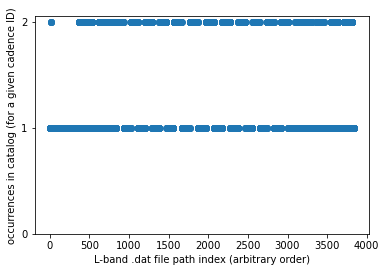

In [6]:
#  Investigating the duplicates further:
l_cadence_IDs = dfl['Cadence ID'].values
l_cadence_dat_lineup = np.transpose(np.array([l_cadence_IDs, l_dat_paths]).astype('str'))
print(f'At L-band, there are {len(np.unique(l_cadence_dat_lineup, axis=0))} unique .dat files in the catalog out of {len(l_cadence_dat_lineup)} overall,')
print(f'suggesting {len(l_cadence_dat_lineup) - len(np.unique(l_cadence_dat_lineup, axis=0))} duplicates.')
print('We plot to confirm:')

counts = []
duplicate_dats = []
for dat in np.unique(l_dat_paths):
    count = len(np.where(l_dat_paths == dat)[0])
    counts.append(count)
    if count == 2:
        duplicate_dats.append(dat)

plt.plot(counts, ls='', marker='o')
plt.xlabel('L-band .dat file path index (arbitrary order)')
plt.ylabel('occurrences in catalog (for a given cadence ID)')
plt.yticks([0, 1, 2])
plt.show()

In [7]:
#  The plot suggests that several .dat files appear twice for a single cadence ID.
#  The number is actually 1612, not 1608 — reflected in the 'counts' vector and the plot but not in the calculation above.
#  This is because 4 observations of Bol 520 are part of two separate cadences (IDs 24789 and 24791) —
#  so there are 1608 duplicate .dat/cadence combinations, although there are 1612 duplicate .dats.

df_bol520 = dfl.iloc[np.where(dfl['Target'].values == 'BOL520')[0]]
for i in range(len(df_bol520['Target'].values)):
    c = df_bol520['Cadence ID'].values[i]
    d = df_bol520['.dat path'].values[i]
    print(f'{c}      {d}')

24789      /home/obs/turboseti/AGBT18A_999_103/collate/spliced_blc0001020304050607_guppi_58306_39511_Bol520_0014.gpuspec.0000/spliced_blc0001020304050607_guppi_58306_39511_Bol520_0014.gpuspec.0000.dat
24789      /home/obs/turboseti/AGBT18A_999_103/collate/spliced_blc0001020304050607_guppi_58306_40134_Bol520_off_0015.gpuspec.0000/spliced_blc0001020304050607_guppi_58306_40134_Bol520_off_0015.gpuspec.0000.dat
24789      /home/obs/turboseti/AGBT18A_999_103/collate/spliced_blc0001020304050607_guppi_58306_40769_Bol520_0016.gpuspec.0000/spliced_blc0001020304050607_guppi_58306_40769_Bol520_0016.gpuspec.0000.dat
24789      /home/obs/turboseti/AGBT18A_999_103/collate/spliced_blc0001020304050607_guppi_58306_41409_Bol520_off_0017.gpuspec.0000/spliced_blc0001020304050607_guppi_58306_41409_Bol520_off_0017.gpuspec.0000.dat
24789      /home/obs/turboseti/AGBT18A_999_103/collate/spliced_blc0001020304050607_guppi_58306_42049_Bol520_0018.gpuspec.0000/spliced_blc0001020304050607_guppi_58306_42049_Bol520_0

In [8]:
#  Grabbing all the duplicate hits, we can run a couple statistical tests on them.

duplicate_hit_files = []
duplicate_hit_frequencies = []
for dat_path in duplicate_dats:
    df_dat = pd.read_table(dat_path, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    for freq in df_dat['Uncorrected_Frequency'].values:
        duplicate_hit_files.append(dat_path)
        duplicate_hit_frequencies.append(freq)

duplicate_hit_frequencies = np.array(duplicate_hit_frequencies)
duplicate_hit_files = np.array(duplicate_hit_files)

#  trim the duplicates to sensitivity range
idxs = np.where(
    ((duplicate_hit_frequencies > 1100) & (duplicate_hit_frequencies < 1200))
    |
    ((duplicate_hit_frequencies > 1340) & (duplicate_hit_frequencies < 1900))
)[0]

duplicate_hit_frequencies_in_range = duplicate_hit_frequencies[idxs]
duplicate_hit_files_in_range = duplicate_hit_files[idxs]

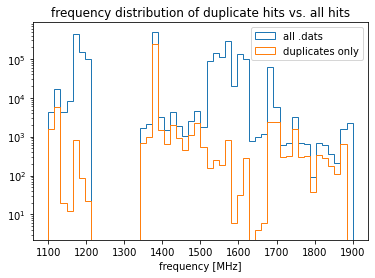

In [9]:
#  Plotting first the relative frequency distribution

plt.hist(list_of_hit_positions_in_range[:,0].astype('float64'), bins=50, range=(1100, 1900), histtype='step', label='all .dats')
plt.hist(duplicate_hit_frequencies_in_range, bins=50, range=(1100, 1900), histtype='step', label='duplicates only')
plt.yscale('log')
plt.xlabel('frequency [MHz]')
plt.title('frequency distribution of duplicate hits vs. all hits')
plt.legend()
plt.show()

In [10]:
#  get hit counts for each .dat file
_, hit_counts = np.unique(duplicate_hit_files_in_range, return_counts=True)
_, hit_counts_all = np.unique(np.unique(list_of_hit_positions_in_range, axis=0)[:,1], return_counts=True)

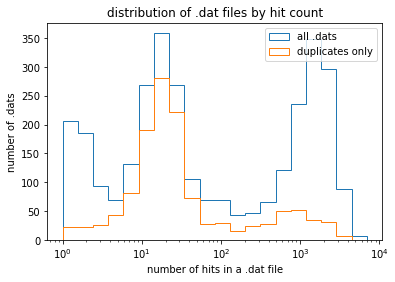

In [17]:
#  Investigate trends among the .dats that were being duplicated.
#  This plots the distribution of .dats by the number of hits they contain,
#  and shows that it's mostly .dats with hit counts in the 5–30 range that
#  got duplicated. (Note that the range of hit counts is 1 to 6799!)

def plot_loghist(x, bins, range, label):
  hist, bins = np.histogram(x, bins=bins, range=range)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins, histtype='step', range=range, label=label)
  plt.xscale('log')

plot_loghist(hit_counts_all, 20, (1,7000), 'all .dats')
plot_loghist(hit_counts, 20, (1,7000), 'duplicates only')
plt.xlabel('number of hits in a .dat file')
plt.ylabel('number of .dats')
plt.title('distribution of .dat files by hit count')
#plt.yscale('log')
plt.legend()
plt.show()

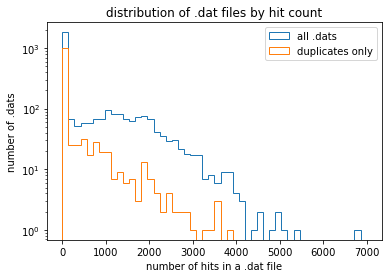

In [18]:
#  This generates a version of the above plot with linear x-axis and logarithmic y-axis,
#  highlighting the skew of the duplicates toward the lower hit count range.

plt.hist(hit_counts_all, range=(0,7000), bins=50, histtype='step', label='all .dats')
plt.hist(hit_counts, range=(0,7000), bins=50, histtype='step', label='duplicates only')
plt.yscale('log')
plt.xlabel('number of hits in a .dat file')
plt.ylabel('number of .dats')
plt.title('distribution of .dat files by hit count')
plt.legend()
plt.show()